# Network Engineering in the AI Era

## Module 4.2 - Introduction to Agentic AI

Welcome to this module on Agentic AI using LangGraph!
In this notebook, we'll explore what agents are, how they operate, and build a practical example of an AI agent that can help with network configuration tasks.

### What are AI Agents?

AI agents are autonomous or semi-autonomous systems that can:

- Perceive their environment through inputs
- Reason about the information they receive
- Plan a course of action
- Execute actions to achieve specific goals
- Learn from feedback and experiences

Unlike simple models that just respond to prompts, agents can maintain state, make decisions, and take actions in a sequence to accomplish complex tasks.

Key Components of AI Agents
- Memory: Ability to store and recall information from previous interactions
- Tools: Functions or APIs that the agent can use to interact with external systems
- Planning: Ability to break down complex tasks into manageable steps
- Reasoning: Capability to make decisions based on available information
- Reflection: Ability to evaluate its own performance and adjust strategies

### LangGraph: Building Stateful Multi-Agent Systems

LangGraph is a library for building stateful, multi-agent applications with LLMs.
It extends LangChain's capabilities by providing:

- A framework for creating directed graphs where nodes represent agent states
- Tools for managing transitions between states
- Methods for handling complex workflows with multiple agents

Let's start by installing the necessary libraries:

In [ ]:
!pip install langchain langchain-anthropic langchain-aws langchain-community langgraph


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Setting Up Our Environment

In [21]:
from langchain_aws import ChatBedrock

try:
    from google.colab import userdata
    import os

    os.environ["AWS_ACCESS_KEY_ID"] = userdata.get("AWS_ACCESS_KEY_ID")
    os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get("AWS_SECRET_ACCESS_KEY")
    os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
except ImportError:
    pass

llm = ChatBedrock(model="us.anthropic.claude-3-7-sonnet-20250219-v1:0", temperature=0)

### Building Our Agent's Components

Our graph will have a single agent (the assistant) and some available tools.

Let's start by defining the tools, and begin with our **Policy Lookup Tool**

In [12]:
import re
from typing import Annotated
from langchain_aws import BedrockEmbeddings
import numpy as np
from langchain_core.tools import tool

embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")

policies_markdown = """
# Policies

## Interface Descriptions

Interface descriptions should include the following information:

- The purpose of the interface
- The subnet and network mask of the interface. E.g., 192.168.0.0/30
- The VLAN ID (if applicable)

## Physical Access to Devices

In order to access physical devices inside a data center, you need to take the Security Compliance training SEC12345.
This training is required for all personnel who need access to the data center.
"""

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", policies_markdown)]


class VectorStoreRetriever:
    """A simple retriever that uses a vector store to retrieve documents."""

    def __init__(self, docs: list, client=embeddings):
        self._client = client
        self._vectors = client.embed_documents([doc["page_content"] for doc in docs])
        self._arr = np.array(self._vectors)
        self._docs = docs

    def query(self, query: str, k: int = 5) -> list[dict]:
        """Query the retriever."""
        embedding = self._client.embed_query(query)
        # "@" is just a matrix multiplication in python
        scores = np.array(embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever(docs)


@tool
def lookup_policy(
    query: Annotated[str, "The query to look for in the company policies."],
) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any network changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

Now that we have done that, let's proceed with creating a tool that will allow the agent to configure devices. In this example, our tool will simulate sending the configuration to a device, and will instead print the configuration to the console. In a real-world scenario, you would replace this with actual code that sends the configuration to a device for example via RESTCONF or NETCONF.

In [13]:
from typing import Annotated

from langchain_core.tools import tool

configuration_template = """
interface {interface_name}
    description {interface_description}
    ip address {interface_ipv4_address} {interface_ipv4_subnet_mask}
    no shutdown
"""


@tool
def configure_device(
    device_name: Annotated[str, "The name of the device to configure."],
    interface_name: Annotated[
        str,
        "The interface name to apply the configuration to. E.g., 'GigabitEthernet0/1'",
    ],
    interface_description: Annotated[str, "The description to set for the interface."],
    interface_ipv4_address: Annotated[
        str, "The IPv4 address to assign to the interface. E.g., 192.168.1.1"
    ],
    interface_ipv4_subnet_mask: Annotated[
        str, "The IPv4 subnet mask to assign to the interface. E.g., 255.255.255.0"
    ],
) -> bool:
    """Use this tool to configure the interface of a device."""
    configuration = configuration_template.format(
        interface_name=interface_name,
        interface_description=interface_description,
        interface_ipv4_address=interface_ipv4_address,
        interface_ipv4_subnet_mask=interface_ipv4_subnet_mask,
    )
    print(configuration)
    return True

Let's create an array that will contain the list of tools that will be available to our agent. The first tool we'll define is the policy lookup tool. This tool will allow the agent to look up network policies in the knowledge base.

In [22]:
available_tools = [
    lookup_policy,
    configure_device,
]

Let's create our assistant agent that will have access to all the available tools. We'll define the agent as a class. This will allow us to easily add more tools in the future if needed.

In [23]:
from datetime import datetime

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph import MessagesState

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for ACME Service Provider. "
            "Use the provided tools to create resources or to search for procedures, company policies, and other information to assist the user's queries. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


class Assistant:
    """Assistant node for the graph."""

    def __init__(self):
        """Initialize the assistant."""
        self.runnable: Runnable = primary_assistant_prompt | llm.bind_tools(
            available_tools
        )

    def __call__(self, state: MessagesState, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

Building the Agent Graph
Now, let's connect all these components into a graph using LangGraph:

In [24]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode

# Create the graph
workflow = StateGraph(MessagesState)

# Add nodes: these do the work
workflow.add_node("assistant", Assistant())
workflow.add_node("tools", ToolNode(available_tools))

# Define edges: these determine how the control flow moves
workflow.add_edge(START, "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("tools", "assistant")

graph = workflow.compile()


Let's visualize our graph to see how the nodes are connected:

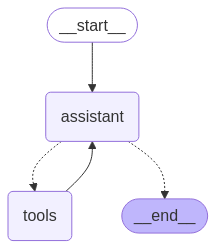

In [25]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Using Our Network Configuration Agent
Let's create a function to interact with our agent:

Example Usage
Let's test our agent with a few examples. Let's begin with asking our agent the following: **I need to create a new VLAN for my database server.**

In [26]:
import rich
from langchain_core.messages import HumanMessage

for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="I need help configuring the interface GigabitEthernet1/0/0 on device CTG-EDGE-001 with IPv4 address 10.1.2.1 and a mask of /30, this interface will be used to connect to BOG-CORE-001 router."
            )
        ]
    },
    stream_mode="updates",
):
    rich.print(event)


{
    'assistant': {
        'messages': AIMessage(
            content="I'll help you configure the interface GigabitEthernet1/0/0 on device CTG-EDGE-001. Before 
making any configuration changes, I should check our company policies regarding network changes.",
            additional_kwargs={
                'usage': {'prompt_tokens': 838, 'completion_tokens': 102, 'total_tokens': 940},
                'stop_reason': 'tool_use',
                'thinking': {},
                'model_id': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
                'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'
            },
            response_metadata={
                'usage': {'prompt_tokens': 838, 'completion_tokens': 102, 'total_tokens': 940},
                'stop_reason': 'tool_use',
                'thinking': {},
                'model_id': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
                'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'
            },
            id='run-2cd14fae-7e42-4346-b740-0618a834c7bb-0',
            tool_calls=[
                {
                    'name': 'lookup_policy',
                    'args': {'query': 'network interface configuration'},
                    'id': 'toolu_bdrk_0146zkMDFbvcgioTPyhYHbPf',
                    'type': 'tool_call'
                }
            ],
            usage_metadata={'input_tokens': 838, 'output_tokens': 102, 'total_tokens': 940}
        )
    }
}

{
    'tools': {
        'messages': [
            ToolMessage(
                content='\n## Interface Descriptions\n\nInterface descriptions should include the following 
information:\n\n- The purpose of the interface\n- The subnet and network mask of the interface. E.g., 
192.168.0.0/30\n- The VLAN ID (if applicable)\n\n\n\n# Policies\n',
                name='lookup_policy',
                id='63bf1bec-7148-43c6-be92-087f2604c0e9',
                tool_call_id='toolu_bdrk_0146zkMDFbvcgioTPyhYHbPf'
            )
        ]
    }
}

{
    'assistant': {
        'messages': AIMessage(
            content="Thank you for providing the details. According to our company policies, I need to include a 
proper description for the interface that includes its purpose and subnet information.\n\nI'll now configure the 
interface GigabitEthernet1/0/0 on device CTG-EDGE-001 with the IPv4 address 10.1.2.1 and a subnet mask of /30 
(which is 255.255.255.252 in decimal notation). I'll include a description that mentions this interface connects to
BOG-CORE-001 router.",
            additional_kwargs={
                'usage': {'prompt_tokens': 1013, 'completion_tokens': 314, 'total_tokens': 1327},
                'stop_reason': 'tool_use',
                'thinking': {},
                'model_id': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
                'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'
            },
            response_metadata={
                'usage': {'prompt_tokens': 1013, 'completion_tokens': 314, 'total_tokens': 1327},
                'stop_reason': 'tool_use',
                'thinking': {},
                'model_id': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
                'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'
            },
            id='run-0afd8013-66a9-4610-bb89-38f40e690d55-0',
            tool_calls=[
                {
                    'name': 'configure_device',
                    'args': {
                        'device_name': 'CTG-EDGE-001',
                        'interface_name': 'GigabitEthernet1/0/0',
                        'interface_description': 'Connection to BOG-CORE-001 router - 10.1.2.0/30',
                        'interface_ipv4_address': '10.1.2.1',
                        'interface_ipv4_subnet_mask': '255.255.255.252'
                    },
                    'id': 'toolu_bdrk_0148VyaR88Rx26Cgg4ko3r1i',
                    'type': 'tool_call'
                }
            ],
            usage_metadata={'input_tokens': 1013, 'output_tokens': 314, 'total_tokens': 1327}
        )
    }
}


interface GigabitEthernet1/0/0
    description Connection to BOG-CORE-001 router - 10.1.2.0/30
    ip address 10.1.2.1 255.255.255.252
    no shutdown



{
    'tools': {
        'messages': [
            ToolMessage(
                content='true',
                name='configure_device',
                id='a7f5cabb-7010-4ffc-8ffa-3df49a7a5f73',
                tool_call_id='toolu_bdrk_0148VyaR88Rx26Cgg4ko3r1i'
            )
        ]
    }
}

{
    'assistant': {
        'messages': AIMessage(
            content="Great! I've successfully configured the interface GigabitEthernet1/0/0 on device CTG-EDGE-001 
with the following settings:\n\n- Device: CTG-EDGE-001\n- Interface: GigabitEthernet1/0/0\n- Description: 
Connection to BOG-CORE-001 router - 10.1.2.0/30\n- IPv4 Address: 10.1.2.1\n- Subnet Mask: 255.255.255.252 
(equivalent to /30)\n\nThe configuration has been applied successfully. The interface is now properly set up to 
connect to the BOG-CORE-001 router. Is there anything else you need help with regarding this configuration?",
            additional_kwargs={
                'usage': {'prompt_tokens': 1339, 'completion_tokens': 171, 'total_tokens': 1510},
                'stop_reason': 'end_turn',
                'thinking': {},
                'model_id': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
                'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'
            },
            response_metadata={
                'usage': {'prompt_tokens': 1339, 'completion_tokens': 171, 'total_tokens': 1510},
                'stop_reason': 'end_turn',
                'thinking': {},
                'model_id': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
                'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0'
            },
            id='run-4f838784-5528-4fac-9bfa-b23357f22cdf-0',
            usage_metadata={'input_tokens': 1339, 'output_tokens': 171, 'total_tokens': 1510}
        )
    }
}